# HIIT Pipeline Experimentation Notebook

This notebook provides tools for experimenting with the HIIT detection pipeline and analyzing performance.

In [3]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add the hiit module to the path
sys.path.append('..')

# Import our pipeline modules
from hiit import data_io, detection, metrics, plotting

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## Data Import Functions

In [4]:
def load_and_prepare_data(fit_filename, data_dir='../data'):
    """
    Load FIT file data and prepare it for analysis.
    
    Args:
        fit_filename (str): Name of the FIT file
        data_dir (str): Directory containing the FIT files
    
    Returns:
        pd.DataFrame: Loaded and prepared data
    """
    filepath = os.path.join(data_dir, fit_filename)
    
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"FIT file not found: {filepath}")
    
    # Load the FIT data
    df = data_io.load_fit_data(filepath)
    
    # Basic data cleaning
    if 'heart_rate' in df.columns:
        df['heart_rate'] = df['heart_rate'].ffill().bfill()
    
    if 'enhanced_speed' in df.columns:
        df['enhanced_speed'] = df['enhanced_speed'].ffill().bfill()
    
    print(f"Loaded data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    return df

def get_available_data_files(data_dir='../data'):
    """
    Get list of available FIT files in the data directory.
    
    Args:
        data_dir (str): Directory to search for FIT files
    
    Returns:
        list: List of FIT filenames
    """
    data_path = Path(data_dir)
    fit_files = list(data_path.glob('*.fit'))
    return [f.name for f in fit_files]

def analyze_data_overview(df, title="Data Overview"):
    """
    Create a comprehensive overview of the loaded data.
    
    Args:
        df (pd.DataFrame): The data to analyze
        title (str): Title for the analysis
    """
    print(f"=== {title} ===")
    print(f"Data shape: {df.shape}")
    print(f"Time range: {df.index[0]} to {df.index[-1]}")
    print(f"Duration: {df.index[-1] - df.index[0]}")
    print("\nColumn statistics:")
    
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            print(f"{col}:")
            print(f"  Mean: {df[col].mean():.2f}")
            print(f"  Std: {df[col].std():.2f}")
            print(f"  Min: {df[col].min():.2f}")
            print(f"  Max: {df[col].max():.2f}")
            print(f"  Missing: {df[col].isna().sum()}")
    
    # Plot key metrics if available
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    if 'heart_rate' in df.columns:
        axes[0, 0].plot(df.index, df['heart_rate'])
        axes[0, 0].set_title('Heart Rate')
        axes[0, 0].set_ylabel('BPM')
    
    if 'enhanced_speed' in df.columns:
        axes[0, 1].plot(df.index, df['enhanced_speed'])
        axes[0, 1].set_title('Enhanced Speed')
        axes[0, 1].set_ylabel('Speed')
    
    if 'heart_rate' in df.columns:
        axes[1, 0].hist(df['heart_rate'].dropna(), bins=30, alpha=0.7)
        axes[1, 0].set_title('Heart Rate Distribution')
        axes[1, 0].set_xlabel('BPM')
    
    if 'enhanced_speed' in df.columns:
        axes[1, 1].hist(df['enhanced_speed'].dropna(), bins=30, alpha=0.7)
        axes[1, 1].set_title('Speed Distribution')
        axes[1, 1].set_xlabel('Speed')
    
    plt.tight_layout()
    plt.show()

## Pipeline Execution Functions

In [5]:
def run_hiit_detection_pipeline(df, manual_hint=None, manual_threshold=None, verbose=True):
    """
    Run the complete HIIT detection pipeline.
    
    Args:
        df (pd.DataFrame): Input data
        manual_hint (tuple): Optional (start_idx, end_idx) for manual guidance
        manual_threshold (float): Optional manual correlation threshold
        verbose (bool): Whether to print progress information
    
    Returns:
        dict: Pipeline results including intervals and metrics
    """
    if verbose:
        print("Starting HIIT detection pipeline...")
    
    # Step 1: Detect HIIT period using frequency correlation
    if verbose:
        print("Step 1: Detecting HIIT period...")
    
    start_idx, end_idx, frequency_info = detection.detect_hiit_period_frequency(
        df, manual_hint=manual_hint, manual_threshold=manual_threshold
    )
    
    if start_idx is None or end_idx is None:
        if verbose:
            print("No HIIT period detected!")
        return None
    
    if verbose:
        print(f"HIIT period detected: {start_idx} to {end_idx}")
        print(f"Period duration: {end_idx - start_idx} seconds")
    
    # Step 2: Extract HIIT data
    df_hiit = df.iloc[start_idx:end_idx].copy()
    
    # Step 3: Segment into intervals
    if verbose:
        print("Step 2: Segmenting intervals...")
    
    intervals = detection.segment_intervals_speed_edges(df_hiit)
    
    if not intervals:
        if verbose:
            print("No intervals detected!")
        return None
    
    if verbose:
        print(f"Detected {len(intervals)} intervals")
    
    # Step 4: Calculate metrics
    if verbose:
        print("Step 3: Calculating performance metrics...")
    
    interval_metrics = metrics.calculate_interval_metrics(df, intervals)
    overall_metrics = metrics.calculate_performance_metrics(df, intervals)
    
    results = {
        'start_idx': start_idx,
        'end_idx': end_idx,
        'frequency_info': frequency_info,
        'intervals': intervals,
        'interval_metrics': interval_metrics,
        'overall_metrics': overall_metrics,
        'df_hiit': df_hiit
    }
    
    if verbose:
        print("Pipeline completed successfully!")
        print(f"Overall metrics: {overall_metrics}")
    
    return results

def compare_pipeline_variants(df, variants=None):
    """
    Compare different pipeline configurations.
    
    Args:
        df (pd.DataFrame): Input data
        variants (list): List of variant configurations
    
    Returns:
        dict: Comparison results
    """
    if variants is None:
        variants = [
            {'name': 'Default', 'manual_hint': None, 'manual_threshold': None},
            {'name': 'Conservative', 'manual_hint': None, 'manual_threshold': 0.8},
            {'name': 'Liberal', 'manual_hint': None, 'manual_threshold': 0.4}
        ]
    
    results = {}
    
    for variant in variants:
        print(f"\nTesting variant: {variant['name']}")
        try:
            result = run_hiit_detection_pipeline(
                df, 
                manual_hint=variant.get('manual_hint'),
                manual_threshold=variant.get('manual_threshold'),
                verbose=False
            )
            results[variant['name']] = result
        except Exception as e:
            print(f"Error with variant {variant['name']}: {e}")
            results[variant['name']] = None
    
    return results

## Visualization Functions

In [6]:
def plot_pipeline_results(results, df, title="Pipeline Results"):
    """
    Create comprehensive visualization of pipeline results.
    
    Args:
        results (dict): Pipeline results
        df (pd.DataFrame): Original data
        title (str): Plot title
    """
    if results is None:
        print("No results to plot")
        return
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    fig.suptitle(title, fontsize=16)
    
    # Plot 1: Full timeline with HIIT period highlighted
    axes[0, 0].plot(df.index, df['heart_rate'], alpha=0.7, label='Full Session')
    if 'df_hiit' in results:
        axes[0, 0].plot(results['df_hiit'].index, results['df_hiit']['heart_rate'], 
                         linewidth=2, color='red', label='HIIT Period')
    axes[0, 0].set_title('Heart Rate Timeline')
    axes[0, 0].set_ylabel('BPM')
    axes[0, 0].legend()
    
    # Plot 2: Intervals visualization
    if 'intervals' in results and results['intervals']:
        intervals = results['intervals']
        for i, interval in enumerate(intervals):
            if 'high_start' in interval and 'high_end' in interval:
                start_idx = results['start_idx'] + interval['high_start']
                end_idx = results['start_idx'] + interval['high_end']
                interval_data = df.iloc[start_idx:end_idx]
                axes[0, 1].plot(interval_data.index, interval_data['heart_rate'], 
                                label=f'Interval {i+1}', alpha=0.8)
        axes[0, 1].set_title('Individual Intervals')
        axes[0, 1].set_ylabel('BPM')
        axes[0, 1].legend()
    
    # Plot 3: Interval metrics
    if 'interval_metrics' in results and results['interval_metrics']:
        metrics_df = pd.DataFrame(results['interval_metrics'])
        
        axes[1, 0].scatter(metrics_df['hr_peak'], metrics_df['tau_rise'], 
                           s=100, alpha=0.7)
        axes[1, 0].set_xlabel('Peak Heart Rate (BPM)')
        axes[1, 0].set_ylabel('Rise Time Constant (s)')
        axes[1, 0].set_title('Peak HR vs Rise Time')
        
        axes[1, 1].scatter(metrics_df['tau_rise'], metrics_df['tau_fall'], 
                           s=100, alpha=0.7)
        axes[1, 1].set_xlabel('Rise Time Constant (s)')
        axes[1, 1].set_ylabel('Fall Time Constant (s)')
        axes[1, 1].set_title('Rise vs Fall Time Constants')
    
    # Plot 4: Performance trends
    if 'interval_metrics' in results and results['interval_metrics']:
        metrics_df = pd.DataFrame(results['interval_metrics'])
        
        axes[2, 0].plot(metrics_df['interval_num'], metrics_df['hr_peak'], 
                         marker='o', linewidth=2)
        axes[2, 0].set_xlabel('Interval Number')
        axes[2, 0].set_ylabel('Peak Heart Rate (BPM)')
        axes[2, 0].set_title('Peak HR by Interval')
        
        axes[2, 1].plot(metrics_df['interval_num'], metrics_df['responsiveness'], 
                         marker='o', linewidth=2, color='green')
        axes[2, 1].set_xlabel('Interval Number')
        axes[2, 1].set_ylabel('Responsiveness (avg time constant)')
        axes[2, 1].set_title('Responsiveness by Interval')
    
    plt.tight_layout()
    plt.show()

def plot_comparison_results(comparison_results, df):
    """
    Compare results from different pipeline variants.
    
    Args:
        comparison_results (dict): Results from compare_pipeline_variants
        df (pd.DataFrame): Original data
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Pipeline Variant Comparison', fontsize=16)
    
    # Plot 1: Number of intervals detected
    variant_names = list(comparison_results.keys())
    interval_counts = []
    
    for name in variant_names:
        result = comparison_results[name]
        if result and 'intervals' in result:
            interval_counts.append(len(result['intervals']))
        else:
            interval_counts.append(0)
    
    axes[0, 0].bar(variant_names, interval_counts)
    axes[0, 0].set_title('Number of Intervals Detected')
    axes[0, 0].set_ylabel('Count')
    
    # Plot 2: HIIT period duration
    durations = []
    for name in variant_names:
        result = comparison_results[name]
        if result and 'start_idx' in result and 'end_idx' in result:
            durations.append(result['end_idx'] - result['start_idx'])
        else:
            durations.append(0)
    
    axes[0, 1].bar(variant_names, durations)
    axes[0, 1].set_title('HIIT Period Duration (seconds)')
    axes[0, 1].set_ylabel('Duration')
    
    # Plot 3: Average peak HR
    avg_peak_hr = []
    for name in variant_names:
        result = comparison_results[name]
        if result and 'interval_metrics' in result and result['interval_metrics']:
            metrics_df = pd.DataFrame(result['interval_metrics'])
            avg_peak_hr.append(metrics_df['hr_peak'].mean())
        else:
            avg_peak_hr.append(0)
    
    axes[1, 0].bar(variant_names, avg_peak_hr)
    axes[1, 0].set_title('Average Peak Heart Rate')
    axes[1, 0].set_ylabel('BPM')
    
    # Plot 4: Average responsiveness
    avg_responsiveness = []
    for name in variant_names:
        result = comparison_results[name]
        if result and 'interval_metrics' in result and result['interval_metrics']:
            metrics_df = pd.DataFrame(result['interval_metrics'])
            avg_responsiveness.append(metrics_df['responsiveness'].mean())
        else:
            avg_responsiveness.append(0)
    
    axes[1, 1].bar(variant_names, avg_responsiveness)
    axes[1, 1].set_title('Average Responsiveness')
    axes[1, 1].set_ylabel('Time Constant (s)')
    
    plt.tight_layout()
    plt.show()

## Example Usage

Now let's see what data files are available and run some examples:

Available FIT files:
  - Other6_2025-07-04T16_08_25.fit
  - Other6_2025-07-05T14_33_29.fit
  - Other6_2025-07-07T20_12_07.fit

Loading example file: Other6_2025-07-04T16_08_25.fit
Loaded data shape: (4286, 10)
Columns: ['enhanced_altitude', 'altitude', 'temperature', 'position_lat', 'speed', 'distance', 'enhanced_speed', 'position_long', 'vertical_speed', 'heart_rate']
=== Overview of Other6_2025-07-04T16_08_25.fit ===
Data shape: (4286, 10)
Time range: 2025-07-04 21:08:25 to 2025-07-04 22:19:52
Duration: 0 days 01:11:27

Column statistics:
enhanced_altitude:
  Mean: 203.03
  Std: 15.37
  Min: 181.80
  Max: 233.40
  Missing: 9
altitude:
  Mean: 203.03
  Std: 15.37
  Min: 181.80
  Max: 233.40
  Missing: 9
temperature:
  Mean: 31.23
  Std: 0.85
  Min: 28.00
  Max: 32.00
  Missing: 9
position_lat:
  Mean: 362642994.27
  Std: 45386.95
  Min: 362555310.00
  Max: 362723311.00
  Missing: 889
speed:
  Mean: 2.14
  Std: 0.80
  Min: 0.00
  Max: 3.96
  Missing: 40
distance:
  Mean: 5011.09
  Std:

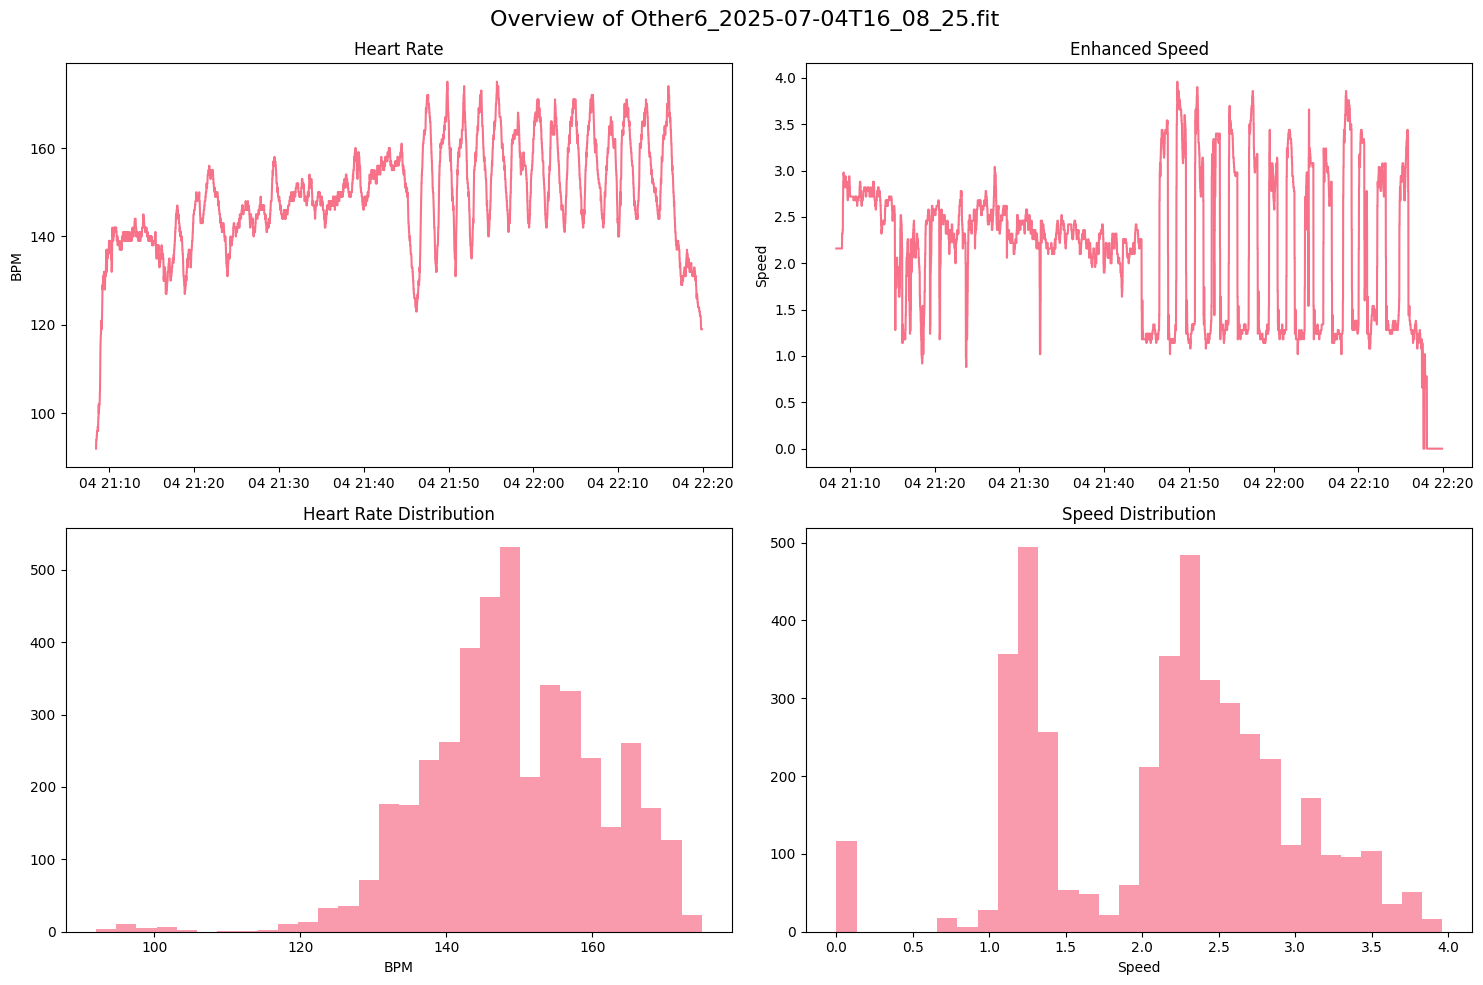

In [7]:
# Check available data files
available_files = get_available_data_files()
print("Available FIT files:")
for file in available_files:
    print(f"  - {file}")

# Load the first available file as an example
if available_files:
    example_file = available_files[0]
    print(f"\nLoading example file: {example_file}")
    
    # Load and analyze the data
    df = load_and_prepare_data(example_file)
    analyze_data_overview(df, f"Overview of {example_file}")

## Pipeline Examples

=== Example 1: Default Pipeline ===
Starting HIIT detection pipeline...
Step 1: Detecting HIIT period...
DEBUG: Parallelizing frequency correlation with 6 cores, 671 positions per chunk
DEBUG: About to call refine_hiit_boundaries with best_start=2150, best_end=4045
DEBUG: refine_hiit_boundaries called with start=2150, end=4045, period=129.87878787878788
DEBUG: Found 6 regions above threshold 0.65
DEBUG: Best correlation region: 2273-2683 (overlap: 410)
DEBUG: Found 8 large speed changes in start search window
DEBUG: Largest speed change at 73, refined start: 2282
DEBUG: Target baseline: 154.6 (HIIT: 123.0, Pre-HIIT: 154.6)
DEBUG: Found 76 baseline points in end search window
DEBUG: Closest baseline at 64, refined end: 2683
DEBUG: Final refined boundaries: 2282-2683
DEBUG: Original boundaries: 2150-4045
DEBUG: Refined boundaries: 2282-2683
DEBUG: Creating template correlation with 4 intervals
DEBUG: Template length: 129
DEBUG: Interval 1: 2284 to 2404 (length: 120)
DEBUG: Segment length

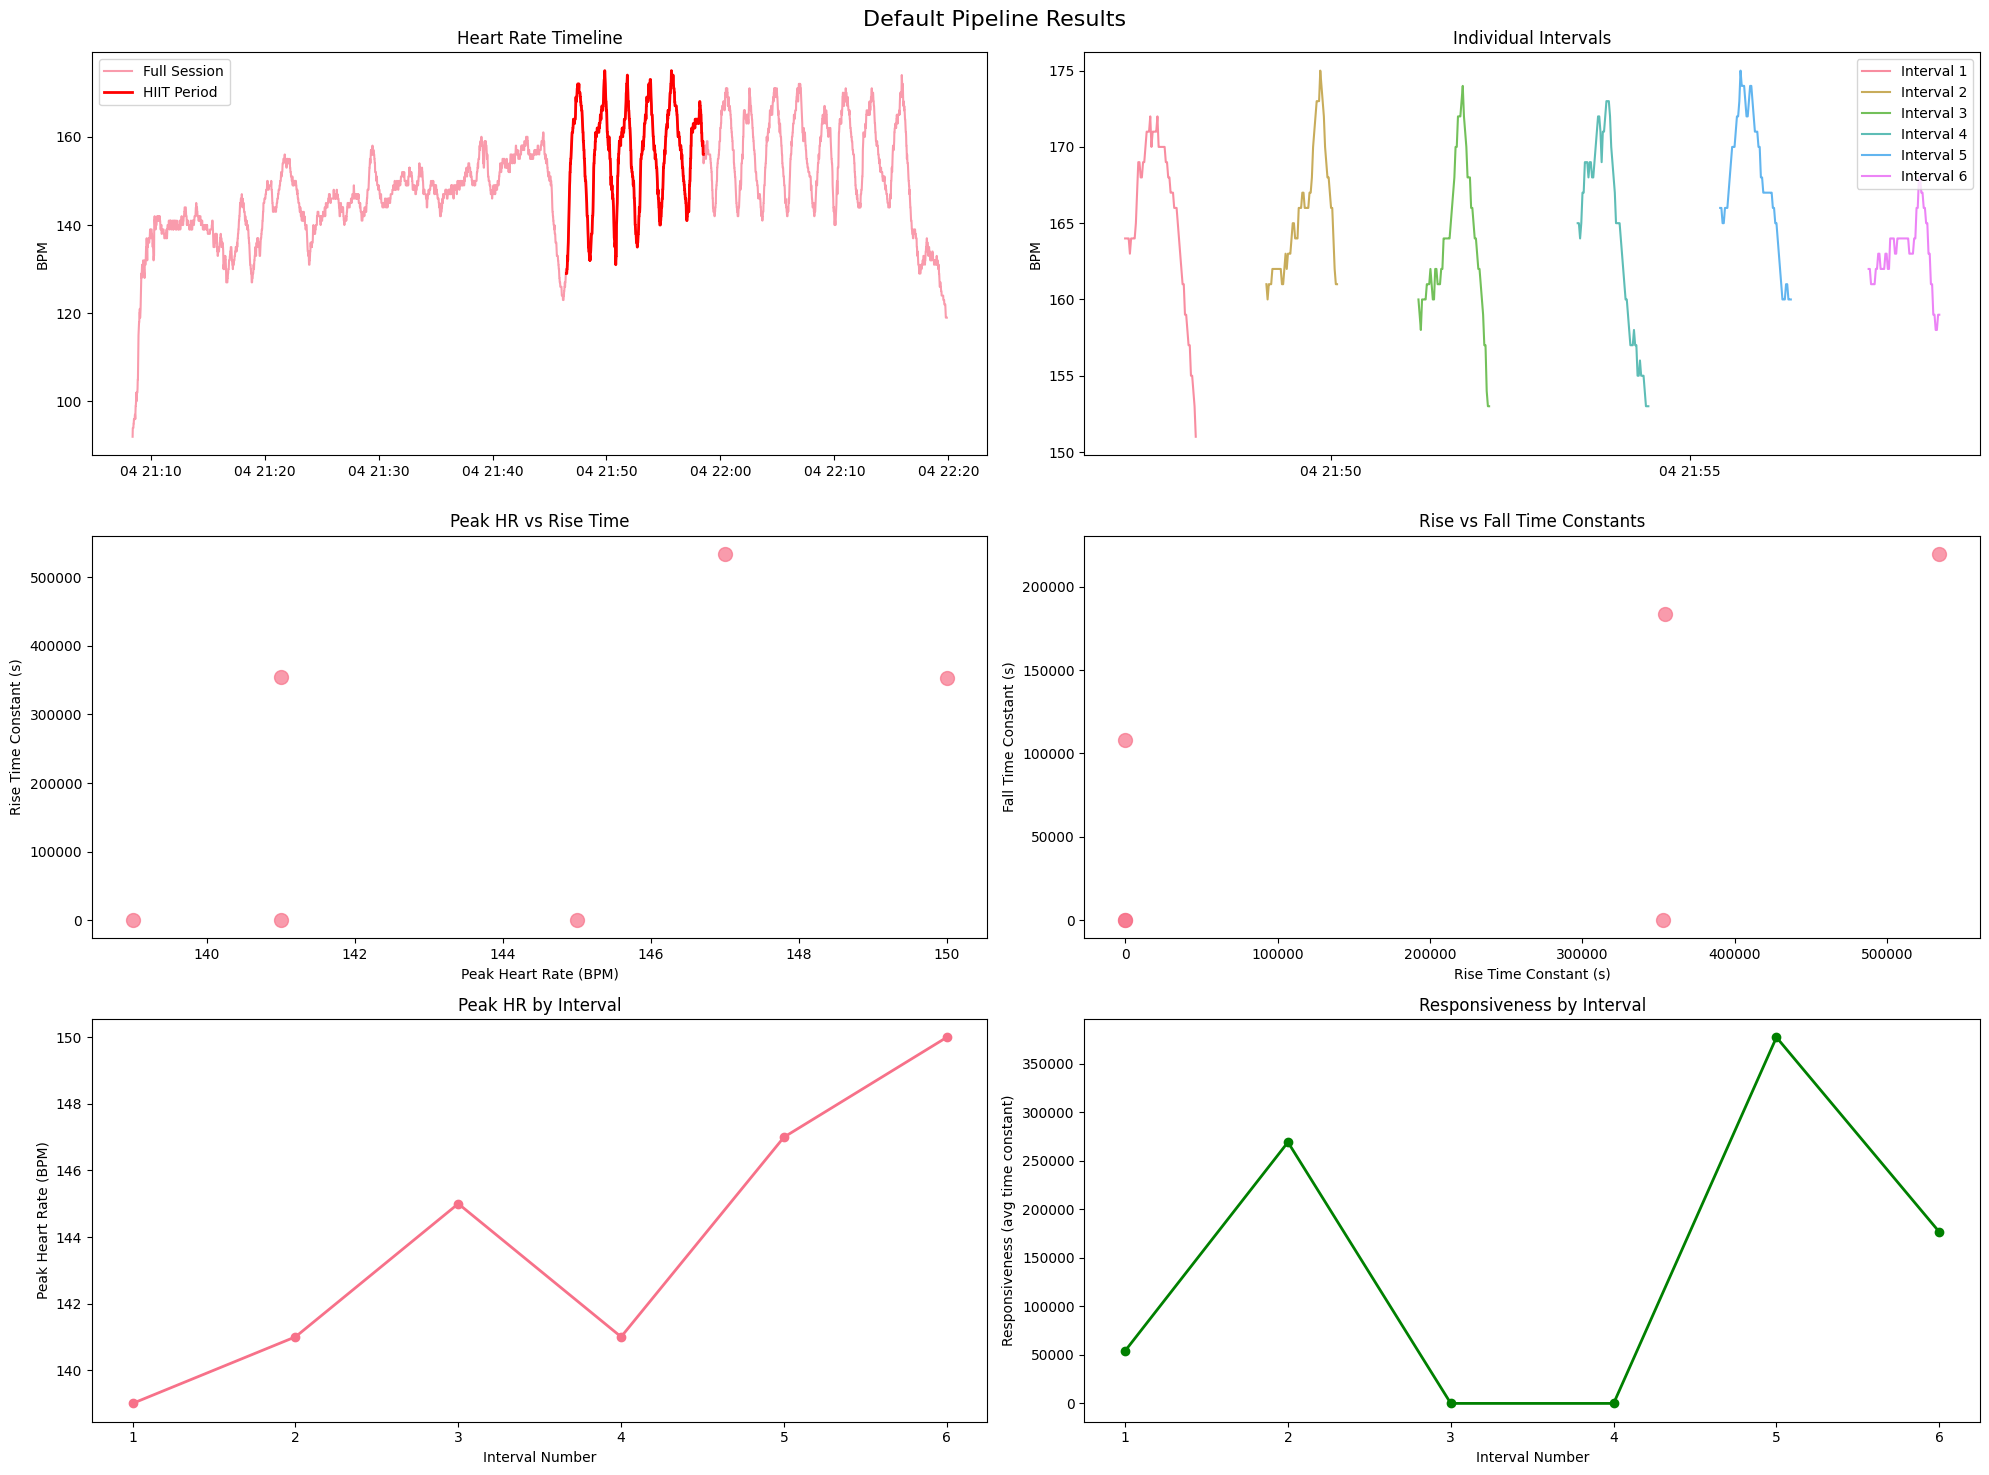


Detailed Results:
HIIT Period: 2282 to 3004 seconds
Number of intervals: 6
Overall metrics: {'num_intervals': 6, 'avg_tau_rise': np.float64(206976.7236593177), 'avg_tau_fall': np.float64(85251.89108385988), 'avg_responsiveness': np.float64(146114.30737158877), 'avg_speed_variability': np.float64(0.042583797992794936), 'avg_hr_peak': np.float64(143.83333333333334), 'avg_hr_baseline': np.float64(132.33333333333334), 'avg_speed_mean': np.float64(2.546698286851746), 'avg_speed_std': np.float64(0.10020536818176858), 'std_tau_rise': np.float64(215530.70129257927), 'std_tau_fall': np.float64(91352.6606595809), 'std_responsiveness': np.float64(141712.3527287885), 'std_speed_variability': np.float64(0.0324056247353614)}


In [8]:
# Example 1: Run the default pipeline
if 'df' in locals():
    print("=== Example 1: Default Pipeline ===")
    results = run_hiit_detection_pipeline(df)
    
    if results:
        plot_pipeline_results(results, df, "Default Pipeline Results")
        
        # Print detailed results
        print(f"\nDetailed Results:")
        print(f"HIIT Period: {results['start_idx']} to {results['end_idx']} seconds")
        print(f"Number of intervals: {len(results['intervals'])}")
        print(f"Overall metrics: {results['overall_metrics']}")
    else:
        print("No HIIT period detected with default settings")

=== Example 2: Pipeline Variant Comparison ===

Testing variant: Default
DEBUG: Parallelizing frequency correlation with 6 cores, 671 positions per chunk
DEBUG: About to call refine_hiit_boundaries with best_start=2150, best_end=4045
DEBUG: refine_hiit_boundaries called with start=2150, end=4045, period=129.87878787878788
DEBUG: Found 6 regions above threshold 0.65
DEBUG: Best correlation region: 2273-2683 (overlap: 410)
DEBUG: Found 8 large speed changes in start search window
DEBUG: Largest speed change at 73, refined start: 2282
DEBUG: Target baseline: 154.6 (HIIT: 123.0, Pre-HIIT: 154.6)
DEBUG: Found 76 baseline points in end search window
DEBUG: Closest baseline at 64, refined end: 2683
DEBUG: Final refined boundaries: 2282-2683
DEBUG: Original boundaries: 2150-4045
DEBUG: Refined boundaries: 2282-2683
DEBUG: Creating template correlation with 4 intervals
DEBUG: Template length: 129
DEBUG: Interval 1: 2284 to 2404 (length: 120)
DEBUG: Segment length: 120, template_length: 129
DEBU

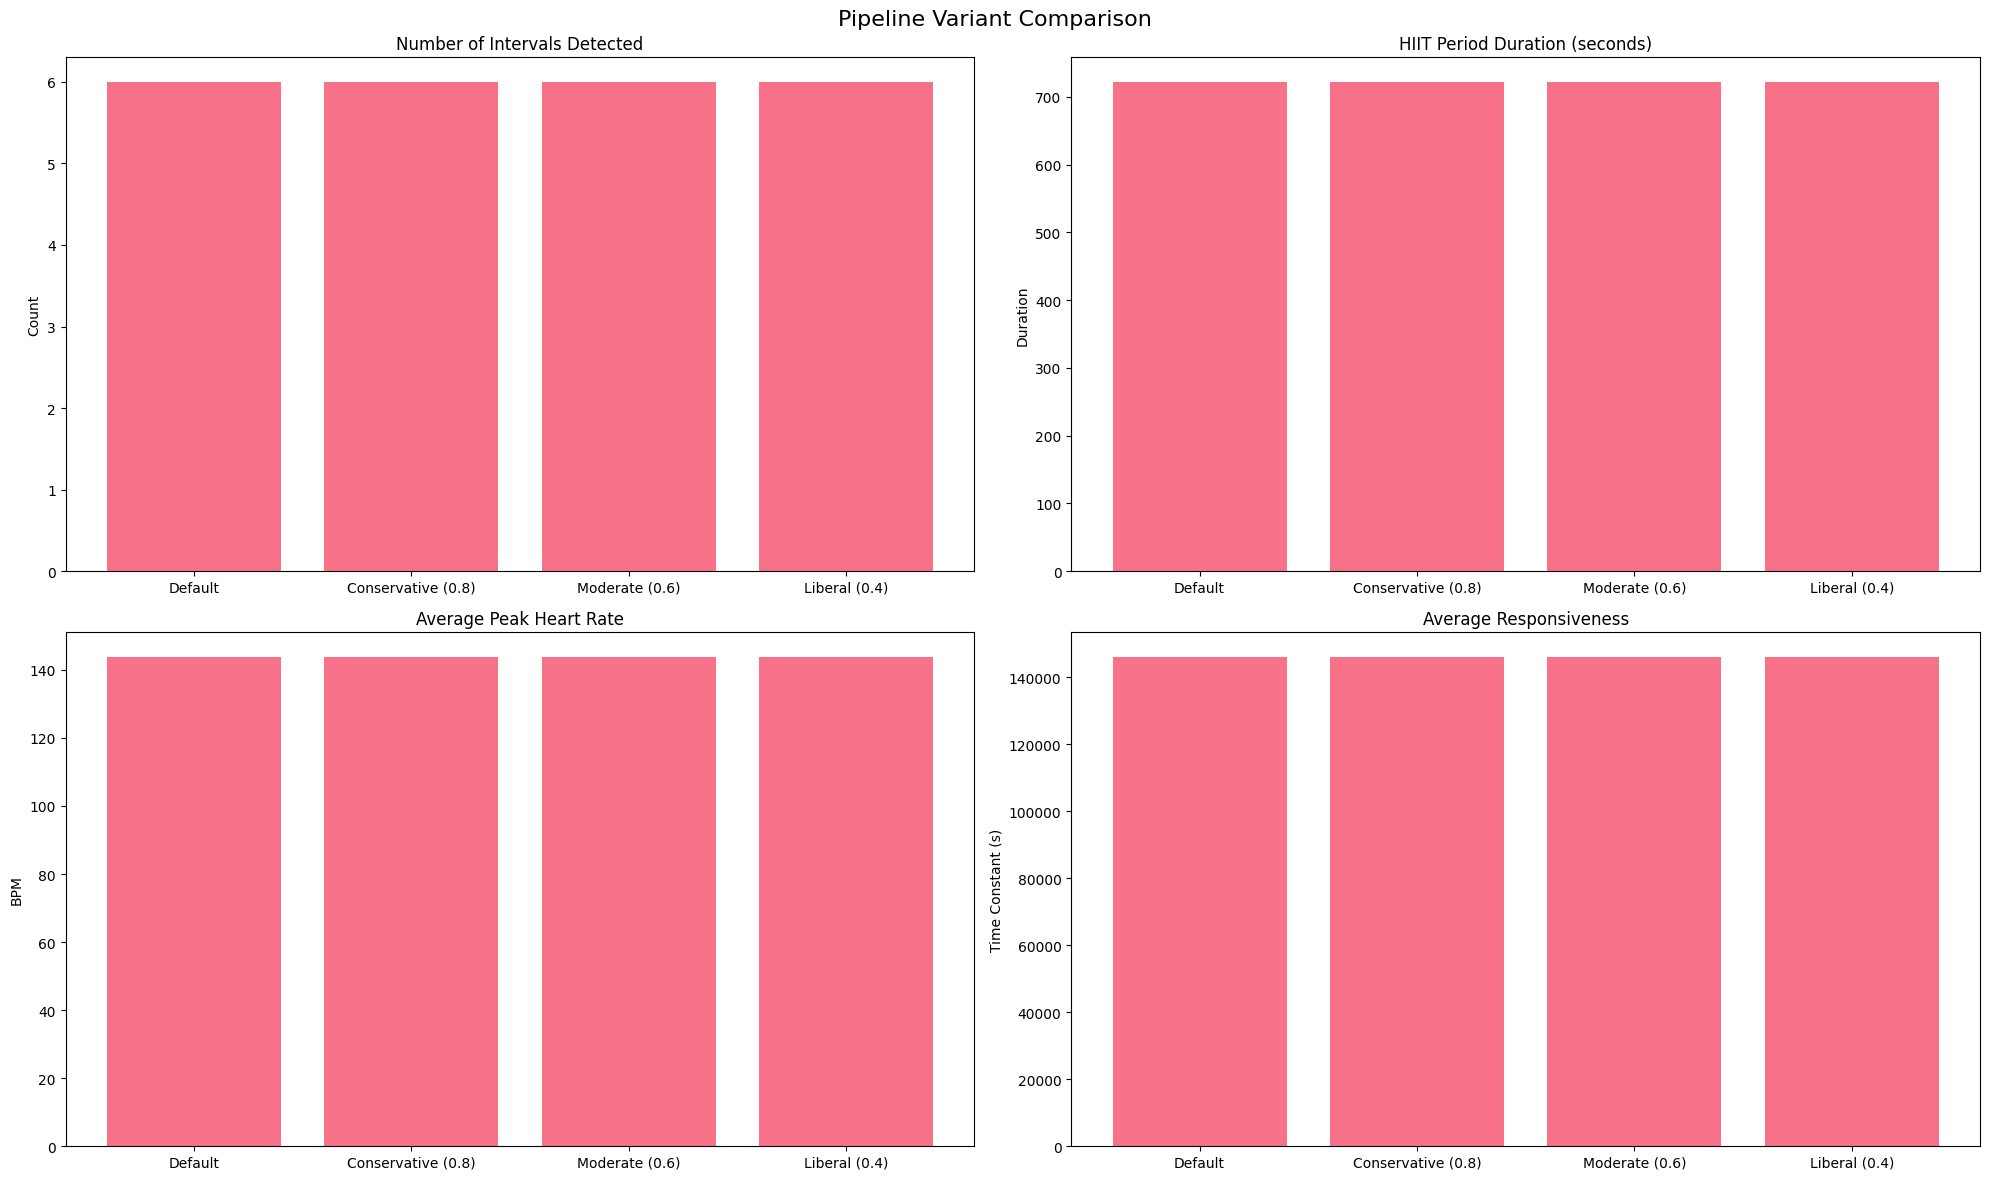


Comparison Summary:
Default: 6 intervals, duration: 722s
Conservative (0.8): 6 intervals, duration: 722s
Moderate (0.6): 6 intervals, duration: 722s
Liberal (0.4): 6 intervals, duration: 722s


In [9]:
# Example 2: Compare different pipeline variants
if 'df' in locals():
    print("=== Example 2: Pipeline Variant Comparison ===")
    
    # Define custom variants
    custom_variants = [
        {'name': 'Default', 'manual_hint': None, 'manual_threshold': None},
        {'name': 'Conservative (0.8)', 'manual_hint': None, 'manual_threshold': 0.8},
        {'name': 'Moderate (0.6)', 'manual_hint': None, 'manual_threshold': 0.6},
        {'name': 'Liberal (0.4)', 'manual_hint': None, 'manual_threshold': 0.4}
    ]
    
    comparison_results = compare_pipeline_variants(df, custom_variants)
    plot_comparison_results(comparison_results, df)
    
    # Print comparison summary
    print("\nComparison Summary:")
    for name, result in comparison_results.items():
        if result:
            print(f"{name}: {len(result['intervals'])} intervals, "
                  f"duration: {result['end_idx'] - result['start_idx']}s")
        else:
            print(f"{name}: No HIIT period detected")

=== Example 3: Manual Window Analysis ===
Trying manual window: 1071 to 3214 seconds
Starting HIIT detection pipeline...
Step 1: Detecting HIIT period...
DEBUG: Parallelizing frequency correlation with 6 cores, 671 positions per chunk
DEBUG: About to call refine_hiit_boundaries with best_start=2150, best_end=4045
DEBUG: refine_hiit_boundaries called with start=2150, end=4045, period=129.87878787878788
DEBUG: Found 6 regions above threshold 0.65
DEBUG: Best correlation region: 2273-2683 (overlap: 410)
DEBUG: Found 8 large speed changes in start search window
DEBUG: Largest speed change at 73, refined start: 2282
DEBUG: Target baseline: 154.6 (HIIT: 123.0, Pre-HIIT: 154.6)
DEBUG: Found 76 baseline points in end search window
DEBUG: Closest baseline at 64, refined end: 2683
DEBUG: Final refined boundaries: 2282-2683
DEBUG: Original boundaries: 2150-4045
DEBUG: Refined boundaries: 2282-2683
DEBUG: Creating template correlation with 4 intervals
DEBUG: Template length: 129
DEBUG: Interval 1:

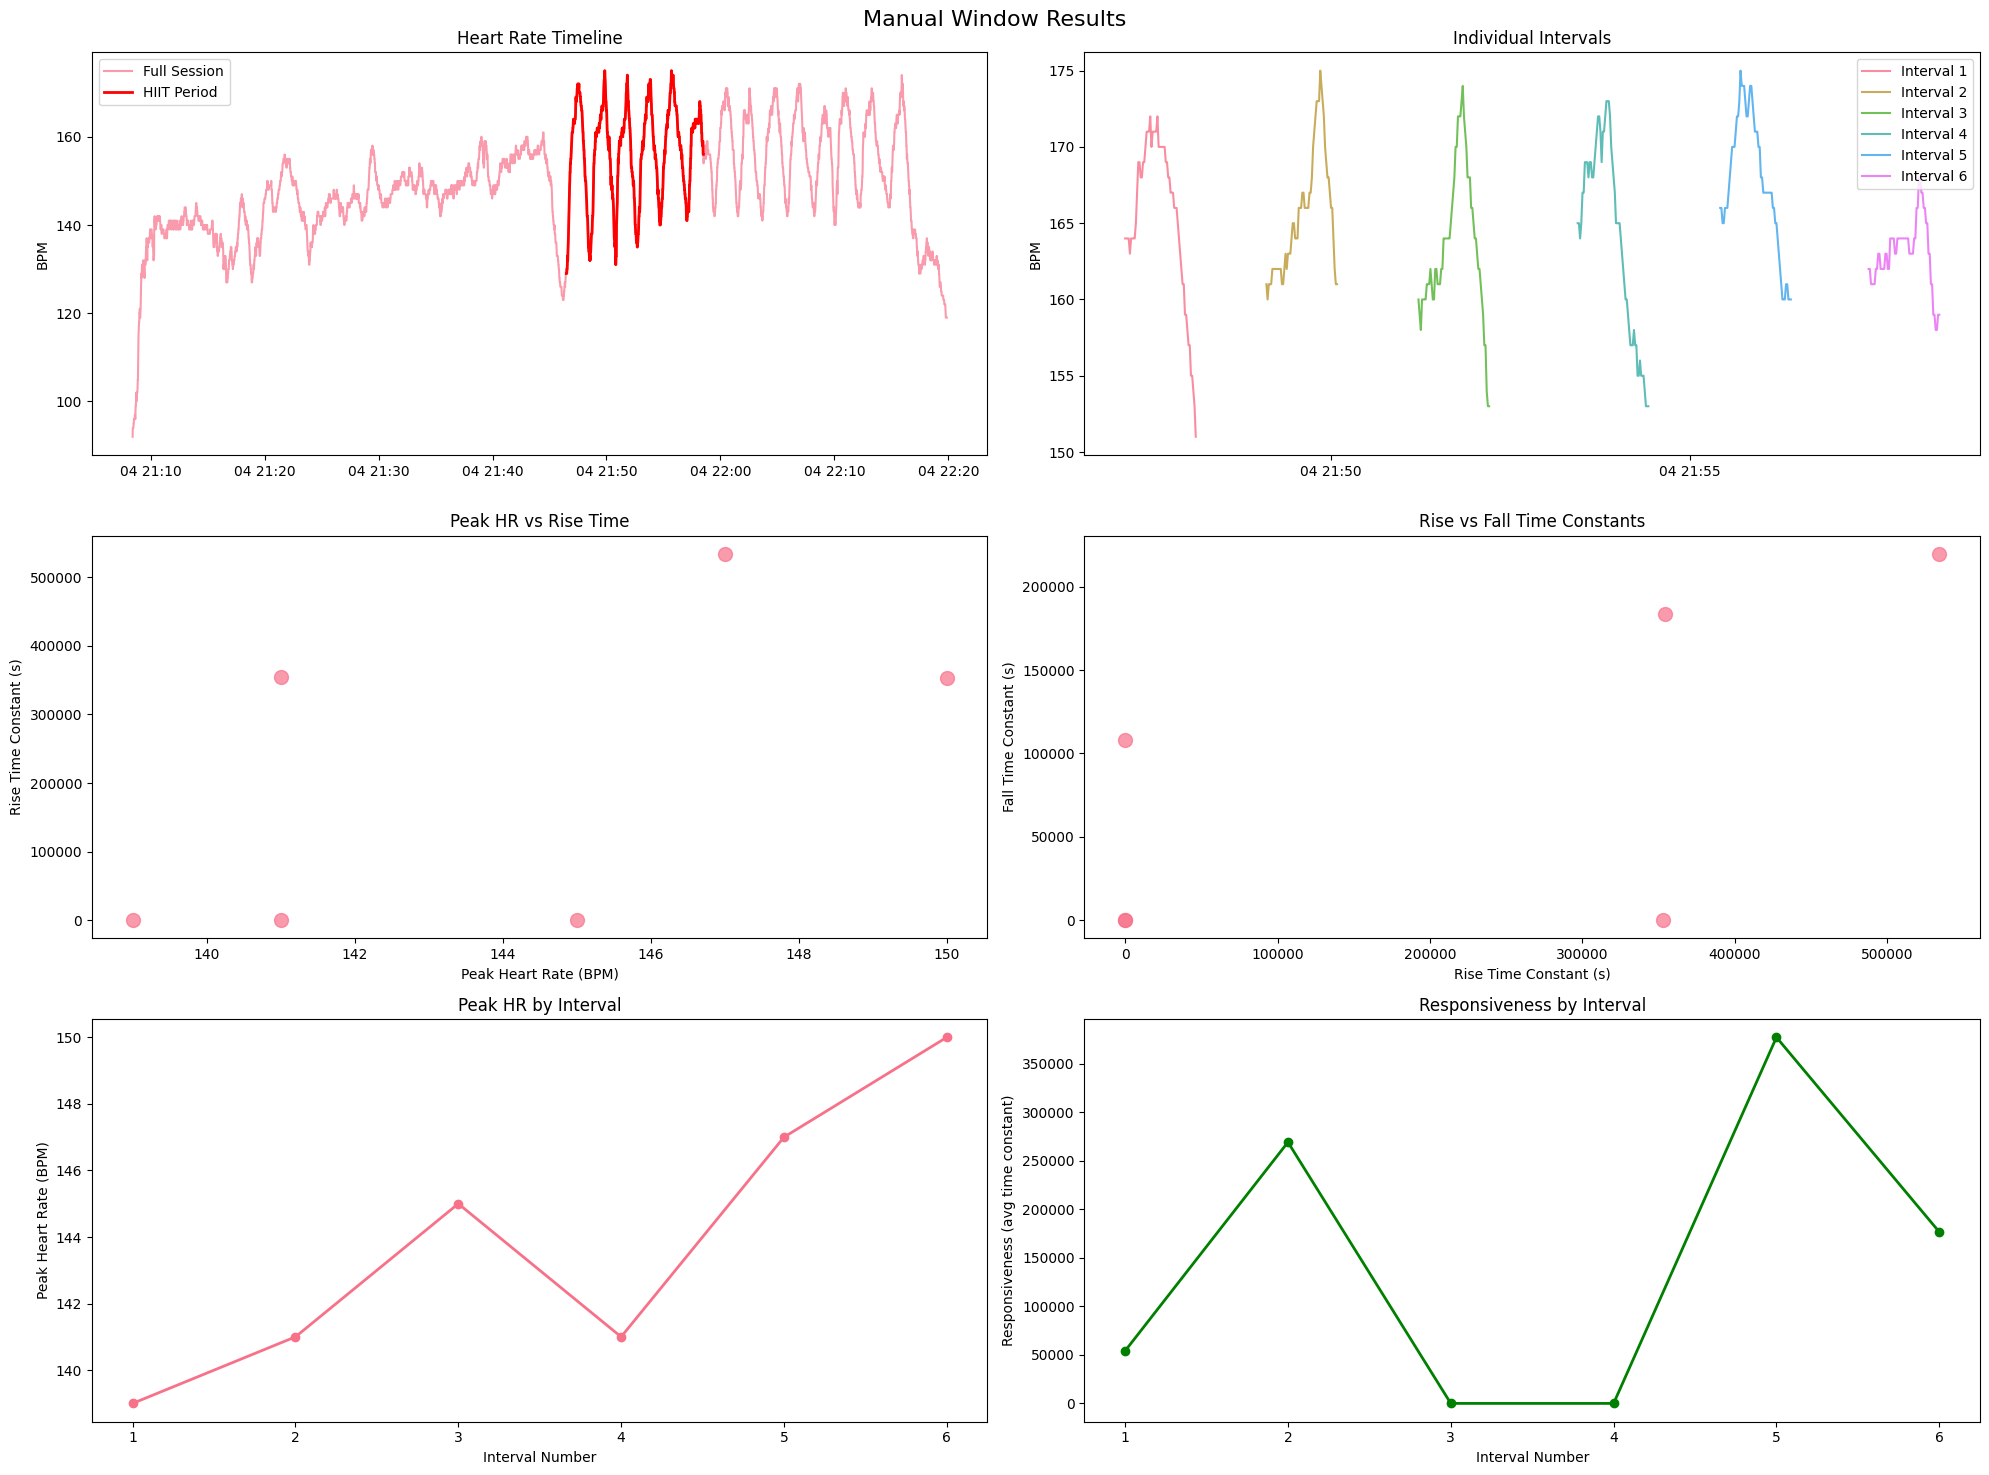

In [10]:
# Example 3: Manual window analysis
if 'df' in locals():
    print("=== Example 3: Manual Window Analysis ===")
    
    # Let's try with a manual hint (you can adjust these values)
    # This is useful when you know roughly where the HIIT period should be
    manual_start = len(df) // 4  # Start at 25% into the session
    manual_end = 3 * len(df) // 4  # End at 75% into the session
    
    print(f"Trying manual window: {manual_start} to {manual_end} seconds")
    
    results_manual = run_hiit_detection_pipeline(
        df, 
        manual_hint=(manual_start, manual_end),
        verbose=True
    )
    
    if results_manual:
        plot_pipeline_results(results_manual, df, "Manual Window Results")
    else:
        print("No HIIT period detected with manual window")

## Performance Analysis Functions

In [11]:
def analyze_pipeline_performance(results_list, names_list):
    """
    Analyze and compare performance across multiple pipeline runs.
    
    Args:
        results_list (list): List of pipeline results
        names_list (list): List of names for each result
    """
    performance_data = []
    
    for i, (results, name) in enumerate(zip(results_list, names_list)):
        if results and 'interval_metrics' in results:
            metrics_df = pd.DataFrame(results['interval_metrics'])
            
            # Calculate summary statistics
            summary = {
                'name': name,
                'num_intervals': len(results['intervals']),
                'duration': results['end_idx'] - results['start_idx'],
                'avg_peak_hr': metrics_df['hr_peak'].mean(),
                'std_peak_hr': metrics_df['hr_peak'].std(),
                'avg_responsiveness': metrics_df['responsiveness'].mean(),
                'std_responsiveness': metrics_df['responsiveness'].std(),
                'avg_tau_rise': metrics_df['tau_rise'].mean(),
                'avg_tau_fall': metrics_df['tau_fall'].mean()
            }
            performance_data.append(summary)
    
    if performance_data:
        perf_df = pd.DataFrame(performance_data)
        
        # Create performance comparison plots
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Pipeline Performance Comparison', fontsize=16)
        
        # Number of intervals
        axes[0, 0].bar(perf_df['name'], perf_df['num_intervals'])
        axes[0, 0].set_title('Number of Intervals')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Duration
        axes[0, 1].bar(perf_df['name'], perf_df['duration'])
        axes[0, 1].set_title('HIIT Duration (seconds)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Average peak HR
        axes[0, 2].bar(perf_df['name'], perf_df['avg_peak_hr'])
        axes[0, 2].set_title('Average Peak HR')
        axes[0, 2].tick_params(axis='x', rotation=45)
        
        # Average responsiveness
        axes[1, 0].bar(perf_df['name'], perf_df['avg_responsiveness'])
        axes[1, 0].set_title('Average Responsiveness')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Tau rise vs fall
        axes[1, 1].scatter(perf_df['avg_tau_rise'], perf_df['avg_tau_fall'], 
                           s=100, alpha=0.7)
        for i, name in enumerate(perf_df['name']):
            axes[1, 1].annotate(name, (perf_df['avg_tau_rise'].iloc[i], 
                                   perf_df['avg_tau_fall'].iloc[i]))
        axes[1, 1].set_xlabel('Average Tau Rise')
        axes[1, 1].set_ylabel('Average Tau Fall')
        axes[1, 1].set_title('Rise vs Fall Time Constants')
        
        # Peak HR vs Responsiveness
        axes[1, 2].scatter(perf_df['avg_peak_hr'], perf_df['avg_responsiveness'], 
                           s=100, alpha=0.7)
        for i, name in enumerate(perf_df['name']):
            axes[1, 2].annotate(name, (perf_df['avg_peak_hr'].iloc[i], 
                                   perf_df['avg_responsiveness'].iloc[i]))
        axes[1, 2].set_xlabel('Average Peak HR')
        axes[1, 2].set_ylabel('Average Responsiveness')
        axes[1, 2].set_title('Peak HR vs Responsiveness')
        
        plt.tight_layout()
        plt.show()
        
        return perf_df
    else:
        print("No valid results to analyze")
        return None

def export_results(results, filename=None):
    """
    Export pipeline results to JSON format.
    
    Args:
        results (dict): Pipeline results
        filename (str): Optional filename for export
    """
    import json
    from datetime import datetime
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"pipeline_results_{timestamp}.json"
    
    # Convert numpy types to native Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        else:
            return obj
    
    exportable_results = convert_numpy(results)
    
    with open(filename, 'w') as f:
        json.dump(exportable_results, f, indent=2, default=str)
    
    print(f"Results exported to {filename}")

## Your Experimentation Space

Now you have all the tools you need to experiment with your pipeline! Here are some ideas for experiments:

1. **Try different correlation thresholds** to see how they affect detection sensitivity
2. **Test manual window hints** to guide the algorithm when you know roughly where HIIT periods should be
3. **Compare results across different FIT files** to see how the pipeline performs on different types of workouts
4. **Analyze the frequency correlation method** by examining the `frequency_info` in the results
5. **Experiment with the interval segmentation** by modifying the speed edge detection parameters

Feel free to modify the functions above or create new ones for your specific experiments!

In [14]:
dfs = [load_and_prepare_data(x) for x in get_available_data_files()]

Loaded data shape: (4286, 10)
Columns: ['enhanced_altitude', 'altitude', 'temperature', 'position_lat', 'speed', 'distance', 'enhanced_speed', 'position_long', 'vertical_speed', 'heart_rate']
Loaded data shape: (2209, 10)
Columns: ['enhanced_altitude', 'altitude', 'temperature', 'position_lat', 'speed', 'distance', 'enhanced_speed', 'position_long', 'vertical_speed', 'heart_rate']
Loaded data shape: (2605, 10)
Columns: ['enhanced_altitude', 'altitude', 'temperature', 'position_lat', 'speed', 'distance', 'enhanced_speed', 'position_long', 'vertical_speed', 'heart_rate']


NameError: name 'median_filter' is not defined

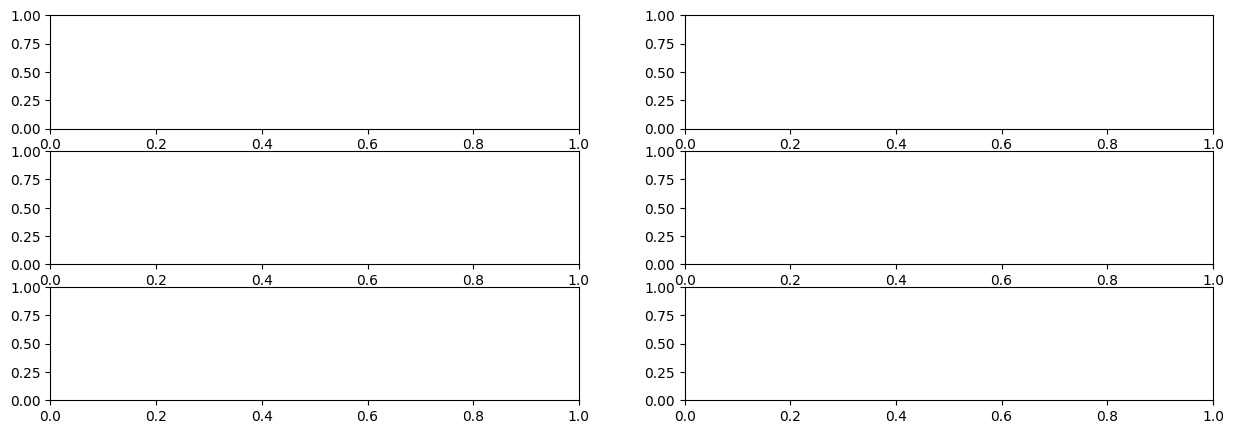

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, filtfilt

fig, axs = plt.subplots(figsize=(15, 5), ncols=2, nrows=3)

def cut_beginning(speed, hr, hr_threshold=140):
    # This function cuts the beginning of the signal to the first time the signal is above 100bpm
    first_ind = np.where(hr > hr_threshold)[0][0]
    # now look for the first inflection point after the first_ind where the derivative of the hr crosses zero
    hr_deriv = np.gradient(hr)
    inflection_ind = np.where(np.diff(hr_deriv) > 0)[0][0]
    return speed[inflection_ind:], hr[inflection_ind:]

def cut_end(speed, hr, speed_threshold=1.0):
    # This function cuts the end of the signal to the last time the signal is above 1.34 m/s
    last_ind = np.where(speed > speed_threshold)[0][-1]
    return speed[:last_ind], hr[:last_ind]

def median_filter(signal, size=10):
    # a simple median filter
    return np.convolve(signal, np.ones(size)/size, mode='same')

def test_process(speed, hr):
    # the signal is sampled at 1hz
    # lowpass filter which allows through frequencies below 1/30hz (i.e. 30 second periodic signals)
    speed = np.gradient(speed)
    hr = np.gradient(hr)
    return speed, hr

def test_isolate(speed, hr):
    # this function isolates the hiit period by looking for signal regions which are p<0.05 above the mean using a normal distribution
    # it takes the mean and std of the signal and then isolates the regions where the signal is p<0.05 above the mean
    # it identifies the approximate start and end of the hiit period by looking for the first and last time the signal is p<0.05 above the mean
    mean = np.mean(speed)
    std = np.std(speed)
    speed = median_filter(speed, size=10)
    hr = median_filter(speed, size=10)
    hiit_ind = np.where(speed > mean + 1.86*std)[0]
    hiit_start = hiit_ind[0]
    hiit_end = hiit_ind[-1]
    # Using the start and end indices, create a mask to be multiplied by the original siganl to isolate the hiit period
    mask = np.zeros(len(speed))
    mask[hiit_start:hiit_end] = 1
    speed_isolated = speed * mask
    hr_isolated = hr * mask
    return speed_isolated, hr_isolated

for axrow, df in zip(axs, dfs):
    ax, ax2 = axrow
    hr, speed = df[['heart_rate', 'enhanced_speed']].values.T
    speed, hr = cut_beginning(speed, hr)
    speed, hr = cut_end(speed, hr)
    hr_processed, speed_processed = test_process(speed, hr)
    hr_isolated, speed_isolated = test_isolate(hr_processed, speed_processed)
    ax.plot(hr, label='heart rate', color='red')
    ax.twinx().plot(speed, label='speed', color='blue')
    ax.legend()
    ax2.plot(hr_processed, label='heart rate', color='red', alpha=0.5)
    ax2.twinx().plot(speed_processed, label='speed', color='blue', alpha=0.5)
    ax2.plot(hr_isolated, label='heart rate', color='green', alpha=0.5)
    ax2.twinx().plot(speed_isolated, label='speed', color='orange', alpha=0.5)
    ax2.legend()
plt.show()